# DCGAN

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, LeakyReLU, Layer, Conv2D, BatchNormalization, Flatten, Conv2DTranspose

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES']="0"

### Generator

In [3]:
class Generator(Model):
    def __init__(self):
        super().__init__()
        self.dense = Dense(7*7*512, use_bias=False, input_shape=(100,))
        self.bn = BatchNormalization() # Batch Normalization
        self.lrelu = LeakyReLU() # LeakyReLU
        
        self.deconv1 = Conv2DTranspose(256, (5, 5), strides=(1, 1), padding='same', use_bias=False)
        self.bn1 = BatchNormalization() # Batch Normalization
        self.lrelu1 = LeakyReLU() # LeakyReLU
        
        self.deconv2 = Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False)
        self.bn2 = BatchNormalization() # Batch Normalization
        self.lrelu2 = LeakyReLU() # LeakyReLU
        
        self.deconv3 = Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same')

    def call(self, x, training=None, mask=None):
        h = self.lrelu(self.bn(self.dense(x), training))
        h = tf.reshape(h, (-1, 7, 7, 512))
        h = self.lrelu1(self.bn1(self.deconv1(h), training))
        h = self.lrelu2(self.bn2(self.deconv2(h), training))
        return self.deconv3(h)

### Discriminator

In [4]:
class Discriminator(Model):
    def __init__(self):
        super().__init__()
        self.conv1 = Conv2D(64, (5, 5), strides=(2, 2), padding='same')
        self.bn1 = BatchNormalization()
        self.lrelu1 = LeakyReLU()
        
        self.conv2 = Conv2D(128, (5, 5), strides=(2, 2), padding='same')
        self.bn2 = BatchNormalization()
        self.lrelu2 = LeakyReLU()
        
        self.flatten = Flatten()
        self.dense = Dense(1, activation='sigmoid')

    def call(self, x, training=None, mask=None):
        h = self.lrelu1(self.bn1(self.conv1(x), training))
        h = self.lrelu2(self.bn2(self.conv2(h), training))
        return self.dense(h)

### Datasets

In [5]:
dataset = tfds.load(name='fashion_mnist', split=tfds.Split.TRAIN)
dataset = dataset.map(lambda x: tf.cast(x['image'], tf.float32) / 255.0).batch(32)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling fashion_mnist-train.tfrecord...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling fashion_mnist-test.tfrecord...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


### Model, Optimizers

In [6]:
generator = Generator()
discriminator = Discriminator()

# Discriminator와 Generator 구분하여 사용해야 한다 
# 서로 다른 모멘텀을 이용해야 하기 때문에 구분
optim_d = tf.optimizers.Adam(1e-4)
optim_g = tf.optimizers.Adam(1e-4)

d_mean = tf.metrics.Mean()
g_mean = tf.metrics.Mean()

### Losses

In [7]:
# BinaryCrossentropy 를 사용 
def discriminator_loss(d_real, d_fake):
    real_loss = tf.keras.losses.BinaryCrossentropy()(tf.ones_like(d_real), d_real) # 진짜인 경우 1에 가깝게 
    fake_loss = tf.keras.losses.BinaryCrossentropy()(tf.zeros_like(d_fake), d_fake) # 가짜인 경우 0에 가깝게 
    return real_loss + fake_loss

def generator_loss(d_fake):
    # 잘 속이게끔 만들어야 하기 때문에 가짜를 1에 가깝게 
    return tf.keras.losses.BinaryCrossentropy()(tf.ones_like(d_fake), d_fake) 

### Training Step

In [9]:
@tf.function
def train_step(image, optim_d, optim_g):
    with tf.GradientTape() as tape_d, tf.GradientTape() as tape_g: # tape_d, tape_g
        z = tf.random.normal([32, 100])
        g = generator(z, training=True)
        
        d_real = discriminator(image, training=True)
        d_fake = discriminator(g, training=True)
        
        d_loss = discriminator_loss(d_real, d_fake)
        g_loss = generator_loss(d_fake)
        
        gradients_d = tape_d.gradient(d_loss, discriminator.trainable_weights)
        gradients_g = tape_g.gradient(g_loss, generator.trainable_weights)
    
    optim_d.apply_gradients(zip(gradients_d, discriminator.trainable_weights))
    optim_g.apply_gradients(zip(gradients_g, generator.trainable_weights))
    return d_loss, g_loss

### Training Loop

epoch: 1, d_loss: 0.9096747636795044, g_loss: 1.0538889169692993


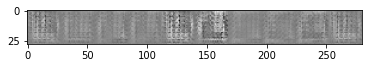

epoch: 2, d_loss: 1.0883409976959229, g_loss: 0.9227266311645508
epoch: 3, d_loss: 1.0699520111083984, g_loss: 0.9431530833244324
epoch: 4, d_loss: 1.0586432218551636, g_loss: 0.9634546637535095
epoch: 5, d_loss: 1.057619333267212, g_loss: 0.9739709496498108
epoch: 6, d_loss: 1.0449488162994385, g_loss: 0.993955671787262
epoch: 7, d_loss: 1.0371640920639038, g_loss: 1.0095816850662231
epoch: 8, d_loss: 1.0253807306289673, g_loss: 1.0293225049972534
epoch: 9, d_loss: 1.0279786586761475, g_loss: 1.0337860584259033
epoch: 10, d_loss: 1.0271573066711426, g_loss: 1.0413157939910889
epoch: 11, d_loss: 1.0395385026931763, g_loss: 1.0348353385925293


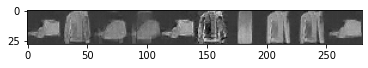

epoch: 12, d_loss: 1.027835726737976, g_loss: 1.0499484539031982
epoch: 13, d_loss: 1.025575876235962, g_loss: 1.0603700876235962
epoch: 14, d_loss: 1.0306928157806396, g_loss: 1.0616263151168823
epoch: 15, d_loss: 1.0255151987075806, g_loss: 1.0697884559631348
epoch: 16, d_loss: 1.0188987255096436, g_loss: 1.0821869373321533
epoch: 17, d_loss: 1.0041874647140503, g_loss: 1.0996617078781128
epoch: 18, d_loss: 1.02871572971344, g_loss: 1.0835587978363037
epoch: 19, d_loss: 1.0244113206863403, g_loss: 1.0917397737503052
epoch: 20, d_loss: 1.034942388534546, g_loss: 1.083706021308899
epoch: 21, d_loss: 1.017324447631836, g_loss: 1.1003129482269287


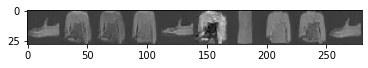

epoch: 22, d_loss: 1.0206526517868042, g_loss: 1.1034921407699585
epoch: 23, d_loss: 1.0290895700454712, g_loss: 1.102946400642395
epoch: 24, d_loss: 1.0091913938522339, g_loss: 1.1159517765045166
epoch: 25, d_loss: 0.9844589233398438, g_loss: 1.1480419635772705
epoch: 26, d_loss: 1.0211915969848633, g_loss: 1.120898723602295
epoch: 27, d_loss: 1.0105303525924683, g_loss: 1.13279128074646
epoch: 28, d_loss: 1.017045021057129, g_loss: 1.1281834840774536
epoch: 29, d_loss: 1.0202255249023438, g_loss: 1.1283090114593506
epoch: 30, d_loss: 1.0465971231460571, g_loss: 1.1107606887817383
epoch: 31, d_loss: 1.0373554229736328, g_loss: 1.1190487146377563


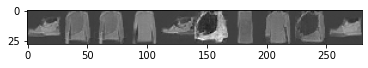

epoch: 32, d_loss: 1.0351874828338623, g_loss: 1.1231701374053955
epoch: 33, d_loss: 1.0228428840637207, g_loss: 1.1323543787002563
epoch: 34, d_loss: 1.0330549478530884, g_loss: 1.1331021785736084
epoch: 35, d_loss: 1.0332982540130615, g_loss: 1.1284700632095337
epoch: 36, d_loss: 1.0264217853546143, g_loss: 1.1351613998413086
epoch: 37, d_loss: 1.0263147354125977, g_loss: 1.1390219926834106
epoch: 38, d_loss: 1.0616486072540283, g_loss: 1.1066856384277344
epoch: 39, d_loss: 1.0533559322357178, g_loss: 1.1126160621643066
epoch: 40, d_loss: 1.041121006011963, g_loss: 1.1275447607040405
epoch: 41, d_loss: 1.0535413026809692, g_loss: 1.1214172840118408


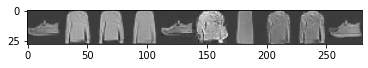

epoch: 42, d_loss: 1.056464433670044, g_loss: 1.1168657541275024
epoch: 43, d_loss: 1.0458109378814697, g_loss: 1.1255913972854614
epoch: 44, d_loss: 1.0586915016174316, g_loss: 1.1203233003616333
epoch: 45, d_loss: 1.0623669624328613, g_loss: 1.114337682723999
epoch: 46, d_loss: 1.0526752471923828, g_loss: 1.1207135915756226
epoch: 47, d_loss: 1.059208869934082, g_loss: 1.1179966926574707
epoch: 48, d_loss: 1.0676175355911255, g_loss: 1.1108978986740112
epoch: 49, d_loss: 1.0791707038879395, g_loss: 1.0996695756912231
epoch: 50, d_loss: 1.0858845710754395, g_loss: 1.0923689603805542
epoch: 51, d_loss: 1.0920041799545288, g_loss: 1.0896083116531372


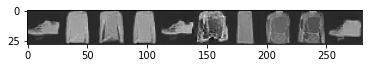

epoch: 52, d_loss: 1.0780948400497437, g_loss: 1.099975347518921
epoch: 53, d_loss: 1.0825526714324951, g_loss: 1.0973917245864868
epoch: 54, d_loss: 1.0920528173446655, g_loss: 1.0937376022338867
epoch: 55, d_loss: 1.0815538167953491, g_loss: 1.103156328201294
epoch: 56, d_loss: 1.073679804801941, g_loss: 1.112794280052185
epoch: 57, d_loss: 1.0928467512130737, g_loss: 1.09540593624115
epoch: 58, d_loss: 1.0822707414627075, g_loss: 1.1024671792984009
epoch: 59, d_loss: 1.0577614307403564, g_loss: 1.12827730178833
epoch: 60, d_loss: 1.0650224685668945, g_loss: 1.1283546686172485
epoch: 61, d_loss: 1.071421504020691, g_loss: 1.1181654930114746


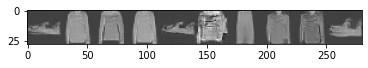

epoch: 62, d_loss: 1.0488903522491455, g_loss: 1.1389586925506592
epoch: 63, d_loss: 1.0780175924301147, g_loss: 1.1110670566558838
epoch: 64, d_loss: 1.0586384534835815, g_loss: 1.1290135383605957


In [ ]:
sample_z = tf.random.normal([10, 100])
for epoch in range(100):
    for image in dataset:
        d_loss, g_loss = train_step(image, optim_d, optim_g)

        d_mean.update_state(d_loss)
        g_mean.update_state(g_loss)

    print('epoch: {}, d_loss: {}, g_loss: {}'.format(epoch+1, d_mean.result(), g_mean.result()))
    
    if epoch % 10 == 0:
        img_list = list()
        sample_img = generator(sample_z)
        for idx in range(sample_img.shape[0]):
            img_list.append(sample_img[idx][:, :, 0])
        img = np.concatenate(img_list, axis=1)
        plt.imshow(img, cmap='gray')
        plt.show()

    d_mean.reset_states()
    g_mean.reset_states()